# 19 - Classifying All-NBA Players (Part I - Manually Selected Boundaries)
Okay, I've taken a look at _**Win Shares**_ and _**VORP**_ so far, and it looked like there was a pretty clear line between all-nba level players and non all-nba level players. Okay, not a _**clear**_ line, but there is a... _**quadrant**_? Let's refresh our memories of what the WS vs VORP plot looks like for a sec.

In [110]:
# Load libraries & initial config
%load_ext rpy2.ipython

%R library(ggplot2)
%R library(gridExtra)
%R library(scales)
%R library(ggbiplot)

%matplotlib nbagg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from StringIO import StringIO
import warnings
warnings.filterwarnings('ignore')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [111]:
# Retrieve team stats from S3
playerAggDfAllNbaAllStar = pd.read_csv('https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/data/playerAggDfAllNbaAllStar.csv', index_col = 0)

pd.set_option('display.max_rows', len(playerAggDfAllNbaAllStar.dtypes))
print playerAggDfAllNbaAllStar.dtypes
pd.reset_option('display.max_rows')

season_start_year          int64
perGameStats_Player       object
perGameStats_Pos          object
perGameStats_Age           int64
perGameStats_Tm           object
perGameStats_G             int64
perGameStats_GS          float64
perGameStats_MP          float64
per100Stats_FG           float64
per100Stats_FGA          float64
per100Stats_FGPerc       float64
per100Stats_3P           float64
per100Stats_3PA          float64
per100Stats_3PPerc       float64
per100Stats_2P           float64
per100Stats_2PA          float64
per100Stats_2PPerc       float64
per100Stats_FT           float64
per100Stats_FTA          float64
per100Stats_FTPerc       float64
per100Stats_ORB          float64
per100Stats_DRB          float64
per100Stats_TRB          float64
per100Stats_AST          float64
per100Stats_STL          float64
per100Stats_BLK          float64
per100Stats_TOV          float64
per100Stats_PF           float64
per100Stats_PTS          float64
per100Stats_ORtg         float64
per100Stat

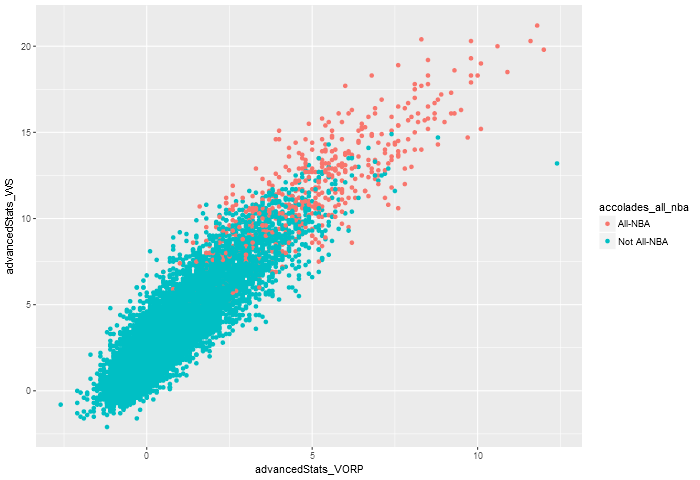

In [112]:
%%R -i playerAggDfAllNbaAllStar -w 700 -u px

allNbaPlot = ggplot(
    NULL
) +
geom_point(
    data = playerAggDfAllNbaAllStar,
    aes(
        x = advancedStats_VORP,
        y = advancedStats_WS,
        color = accolades_all_nba
    )
)

allNbaPlot

## Classification
Okay. So I'm at the crossroads of your classic classification problem... How can I tell what players will be all-stars vs non all-stars? What predictors matter? Here, I have 2 predictors and it seems to paint a relatively simple picture for us because we're looking at only 2 dimensions. It's pretty clear that the

Roughly anyone that's higher than 5 VORP and 10 WS. Done? What does that boundary actually look like?

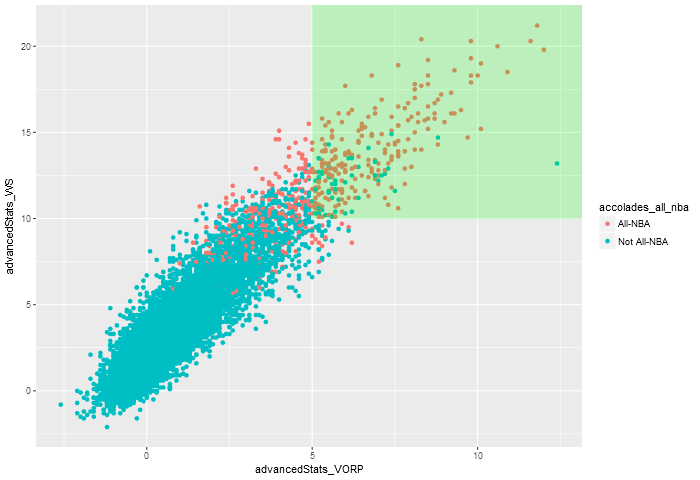

In [113]:
%%R -w 700 -u px

allNbaPlotRect = allNbaPlot + annotate(
    'rect',
    xmin = 5,
    xmax = Inf,
    ymin = 10,
    ymax = Inf,
    fill = 'green',
    alpha = 0.2
)

allNbaPlotRect

This is definitely interesting. It's getting... what... maybe _**half**_ of the all-nba folks? There's still a _**ton**_ of misclassifications here obviously, and to be frank, the decision boundary just... well... _**looks**_ wrong. I don't think it's really optimally separating the two classes. Intuitively, our decision boundary should probably be a horizontal line going from the top left of the graph to the bottom right. This is the axis in which the two classes are overlapping... or... I can't really think of a better way to explain this right now haha, but this is what I mean.

In [114]:
manualDecisionLine = pd.DataFrame({
    'xs': [2, 7.5],
    'ys': [15, 5]
})

In [115]:
%%R -i manualDecisionLine -w 700 -u px

allNbaPlotManualBoundary = allNbaPlotRect + geom_line(
    data = manualDecisionLine
    aes(
        x = xs,
        y = ys
    )
)

allNbaPlotManualBoundary


Error in (function (file = "", n = NULL, text = NULL, prompt = "?", keep.source = getOption("keep.source"),  : 
  <text>:4:5: unexpected symbol
3:     data = manualDecisionLine
4:     aes
       ^


Something like that... Why don't we how each of these fared out if we were to actually use this as a 'model'.

### 'Rectangle' Model

In [116]:
# Predict using our rectangle model
playerAggDfAllNbaAllStar['rect_predict'] = np.where(
    (playerAggDfAllNbaAllStar['advancedStats_VORP'] > 5) & (playerAggDfAllNbaAllStar['advancedStats_WS'] > 10),
    'All-NBA',
    'Not All-NBA'
)

# Label successfully classified and wrongly classified
playerAggDfAllNbaAllStar['rect_predict_labels'] = np.where(
    (playerAggDfAllNbaAllStar['rect_predict'] == 'All-NBA') & (playerAggDfAllNbaAllStar['accolades_all_nba'] == 'All-NBA'),
    'All-NBA - Successfully Classified',
    np.where(
        (playerAggDfAllNbaAllStar['rect_predict'] == 'All-NBA') & (playerAggDfAllNbaAllStar['accolades_all_nba'] == 'Not All-NBA'),
        'All-NBA - Wrongly Classified',
        np.where(
            (playerAggDfAllNbaAllStar['rect_predict'] == 'Not All-NBA') & (playerAggDfAllNbaAllStar['accolades_all_nba'] == 'All-NBA'),
            'Not All-NBA - Wrongly Classified',
            'Not All-NBA - Successfully Classified'
        )
    )
)

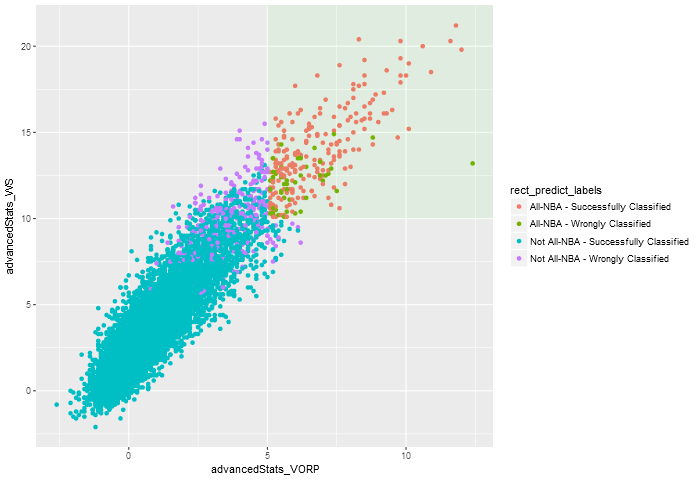

In [117]:
%%R -i playerAggDfAllNbaAllStar -w 700 -u px

# Plot classification of rectangle model
allNbaPlotRect = ggplot(
    NULL
) +
geom_point(
    data = playerAggDfAllNbaAllStar,
    aes(
        x = advancedStats_VORP,
        y = advancedStats_WS,
        color = rect_predict_labels
    )
) + annotate(
    'rect',
    xmin = 5,
    xmax = Inf,
    ymin = 10,
    ymax = Inf,
    fill = 'green',
    alpha = 0.05
)

allNbaPlotRect

In [118]:
# Count the occurences of each prediction outcome
labelCountsRect = playerAggDfAllNbaAllStar['rect_predict_labels'].value_counts()
print labelCountsRect

Not All-NBA - Successfully Classified    12671
Not All-NBA - Wrongly Classified           287
All-NBA - Successfully Classified          215
All-NBA - Wrongly Classified                47
Name: rect_predict_labels, dtype: int64


In [119]:
print 'All-NBA was classified correctly {} / {} ({})'.format(
    labelCountsRect['All-NBA - Successfully Classified'],
    labelCountsRect['All-NBA - Successfully Classified'] + labelCountsRect['Not All-NBA - Wrongly Classified'],
    float(labelCounts['All-NBA - Successfully Classified']) / float(labelCountsRect['All-NBA - Successfully Classified'] + labelCountsRect['Not All-NBA - Wrongly Classified'])*100
)

print 'Not All-NBA was classified correctly {} / {} ({})'.format(
    labelCountsRect['Not All-NBA - Successfully Classified'],
    labelCountsRect['Not All-NBA - Successfully Classified'] + labelCountsRect['All-NBA - Wrongly Classified'],
    float(labelCountsRect['Not All-NBA - Successfully Classified']) / float(labelCountsRect['Not All-NBA - Successfully Classified'] + labelCountsRect['All-NBA - Wrongly Classified'])*100
)

All-NBA was classified correctly 215 / 502 (42.828685259)
Not All-NBA was classified correctly 12671 / 12718 (99.6304450385)


Not All-NBA was classified correctly 99.63% of the time! Holy cow! I think we're done! The All-NBA labels were classified... 42.83% of the time... _**WORSE**_ than a coin flip...

If I were working in Vegas in the front office setting the odds, you think I would be able to pitch a slide deck to my boss saying "I'm 42% this is the correct result"? There's a 100% chance I wouldn't have a job the next day.

### Line Model

Let's check out the manually drawn line, shall we? The line is defined by

$$y=mx+b$$

$$m=\frac{y_2-y_1}{x_2-x_1}$$

$$b=y-mx$$

Therefore

$$m=\frac{5-15}{7.5-2}=-\frac{-10}{5.5}=-1.82$$

$$b=15--\frac{-10}{5.5}2=18.64$$

So the line is

$$y=\frac{-10}{5.5}x+18.64$$

Hmm... how exactly do we tell if a point is on either side of the line? With some quick googling, apparently

$$d=(x−x1)(y2−y1)−(y−y1)(x2−x1)$$

In our case, we're interested in the point

$$p=(x,y)$$

as the point we want to find out about (determine which side of the boundary it falls on), and our two points are the ones we used to create the line in the first place. Let's try to build this model.

In [120]:
# Determine value of d for each sample point
playerAggDfAllNbaAllStar['manual_line_d_value'] = (playerAggDfAllNbaAllStar['advancedStats_VORP']-2)*(5-15)-(playerAggDfAllNbaAllStar['advancedStats_WS']-15)*(7.5-2)

# Predict using our manual line model
playerAggDfAllNbaAllStar['manual_line_predict'] = np.where(
    (playerAggDfAllNbaAllStar['manual_line_d_value'] > 0),
    'All-NBA',
    'Not All-NBA'
)

# Label successfully classified and wrongly classified
playerAggDfAllNbaAllStar['manual_line_labels'] = np.where(
    (playerAggDfAllNbaAllStar['manual_line_predict'] == 'All-NBA') & (playerAggDfAllNbaAllStar['accolades_all_nba'] == 'All-NBA'),
    'All-NBA - Successfully Classified',
    np.where(
        (playerAggDfAllNbaAllStar['manual_line_predict'] == 'All-NBA') & (playerAggDfAllNbaAllStar['accolades_all_nba'] == 'Not All-NBA'),
        'All-NBA - Wrongly Classified',
        np.where(
            (playerAggDfAllNbaAllStar['manual_line_predict'] == 'Not All-NBA') & (playerAggDfAllNbaAllStar['accolades_all_nba'] == 'All-NBA'),
            'Not All-NBA - Wrongly Classified',
            'Not All-NBA - Successfully Classified'
        )
    )
)

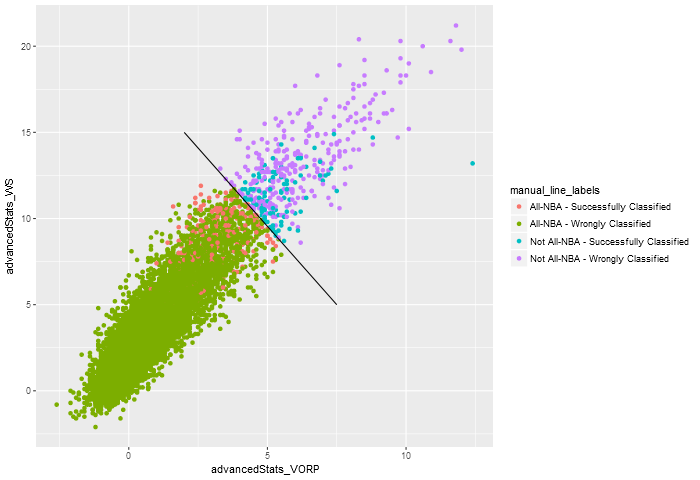

In [121]:
%%R -i playerAggDfAllNbaAllStar -w 700 -u px

# Plot classification of manual line model
allNbaPlotLine = ggplot(
    NULL
) +
geom_point(
    data = playerAggDfAllNbaAllStar,
    aes(
        x = advancedStats_VORP,
        y = advancedStats_WS,
        color = manual_line_labels
    )
) + geom_line(
    data = manualDecisionLine,
    aes(
        x = xs,
        y = ys
    )
)

allNbaPlotLine

In [122]:
# Count the occurences of each prediction outcome
labelCountsLine = playerAggDfAllNbaAllStar['manual_line_labels'].value_counts()
print labelCountsLine

All-NBA - Wrongly Classified             12612
Not All-NBA - Wrongly Classified           295
All-NBA - Successfully Classified          207
Not All-NBA - Successfully Classified      106
Name: manual_line_labels, dtype: int64


In [123]:
print 'All-NBA was classified correctly {} / {} ({})'.format(
    labelCountsLine['All-NBA - Successfully Classified'],
    labelCountsLine['All-NBA - Successfully Classified'] + labelCountsLine['Not All-NBA - Wrongly Classified'],
    float(labelCountsLine['All-NBA - Successfully Classified']) / float(labelCountsLine['All-NBA - Successfully Classified'] + labelCountsLine['Not All-NBA - Wrongly Classified'])*100
)

print 'Not All-NBA was classified correctly {} / {} ({})'.format(
    labelCountsLine['Not All-NBA - Successfully Classified'],
    labelCountsLine['Not All-NBA - Successfully Classified'] + labelCountsLine['All-NBA - Wrongly Classified'],
    float(labelCountsLine['Not All-NBA - Successfully Classified']) / float(labelCountsLine['Not All-NBA - Successfully Classified'] + labelCountsLine['All-NBA - Wrongly Classified'])*100
)

All-NBA was classified correctly 207 / 502 (41.235059761)
Not All-NBA was classified correctly 106 / 12718 (0.833464381192)


Okay, well, according to this, I got All-NBA right 41% of the time and Not All-NBA right 0.8% of the time. That sucks quite a bit. Nah, that sucks A LOT. I imagined giong to my boss and vegas with a 40-something percent model last time... imagine going in with an 0.8% model. Actually, Hopefully I'd be smart enough to recognize that this is pretty much guaranteeing an INCORRECT answer... which means I can switch my answer around everytime and get 99.2% accuracy!

That's what I've recognized here as well. I kinda skipped looking closely at the plot before because I was so mesmerized by the colors, but what has actually happened was that I've misclassified the two categories. I've mixed them up.

Remember back when

$$d=(x−x1)(y2−y1)−(y−y1)(x2−x1)$$

determined our classification? We had to arbitrarily choose that if d > 0, then we chose one class, and when d < 0, we chose the other class. Unfortunately, we chose the wrong class lol. Let's try to flip that around.

In [124]:
# Determine value of d for each sample point
playerAggDfAllNbaAllStar['manual_line_d_value'] = (playerAggDfAllNbaAllStar['advancedStats_VORP']-2)*(5-15)-(playerAggDfAllNbaAllStar['advancedStats_WS']-15)*(7.5-2)

# Predict using our manual line model
##########################################################
##### CHANGE THE SIGN FOR EVALUATING THE D VALUE HERE#####
##########################################################
playerAggDfAllNbaAllStar['manual_line_predict'] = np.where(
    (playerAggDfAllNbaAllStar['manual_line_d_value'] < 0),
    'All-NBA',
    'Not All-NBA'
)

# Label successfully classified and wrongly classified
playerAggDfAllNbaAllStar['manual_line_labels'] = np.where(
    (playerAggDfAllNbaAllStar['manual_line_predict'] == 'All-NBA') & (playerAggDfAllNbaAllStar['accolades_all_nba'] == 'All-NBA'),
    'All-NBA - Successfully Classified',
    np.where(
        (playerAggDfAllNbaAllStar['manual_line_predict'] == 'All-NBA') & (playerAggDfAllNbaAllStar['accolades_all_nba'] == 'Not All-NBA'),
        'All-NBA - Wrongly Classified',
        np.where(
            (playerAggDfAllNbaAllStar['manual_line_predict'] == 'Not All-NBA') & (playerAggDfAllNbaAllStar['accolades_all_nba'] == 'All-NBA'),
            'Not All-NBA - Wrongly Classified',
            'Not All-NBA - Successfully Classified'
        )
    )
)

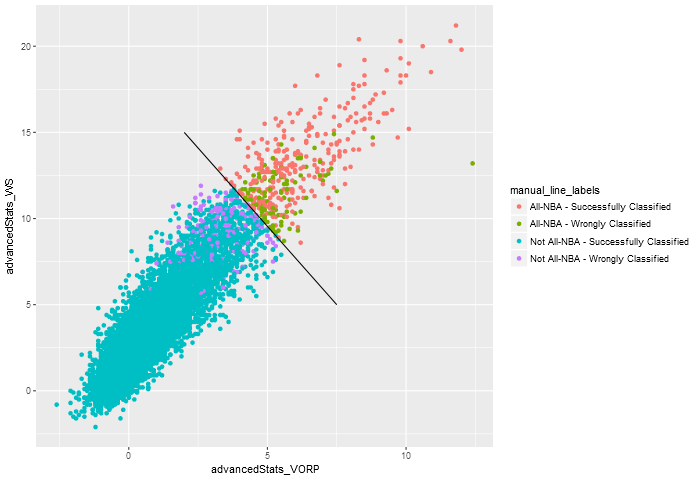

In [125]:
%%R -i playerAggDfAllNbaAllStar -w 700 -u px

# Plot classification of manual line model
allNbaPlotLine = ggplot(
    NULL
) +
geom_point(
    data = playerAggDfAllNbaAllStar,
    aes(
        x = advancedStats_VORP,
        y = advancedStats_WS,
        color = manual_line_labels
    )
) + geom_line(
    data = manualDecisionLine,
    aes(
        x = xs,
        y = ys
    )
)

allNbaPlotLine

In [126]:
# Count the occurences of each prediction outcome
labelCountsLine = playerAggDfAllNbaAllStar['manual_line_labels'].value_counts()
print labelCountsLine

Not All-NBA - Successfully Classified    12613
All-NBA - Successfully Classified          295
Not All-NBA - Wrongly Classified           207
All-NBA - Wrongly Classified               105
Name: manual_line_labels, dtype: int64


In [127]:
print 'All-NBA was classified correctly {} / {} ({})'.format(
    labelCountsLine['All-NBA - Successfully Classified'],
    labelCountsLine['All-NBA - Successfully Classified'] + labelCountsLine['Not All-NBA - Wrongly Classified'],
    float(labelCountsLine['All-NBA - Successfully Classified']) / float(labelCountsLine['All-NBA - Successfully Classified'] + labelCountsLine['Not All-NBA - Wrongly Classified'])*100
)

print 'Not All-NBA was classified correctly {} / {} ({})'.format(
    labelCountsLine['Not All-NBA - Successfully Classified'],
    labelCountsLine['Not All-NBA - Successfully Classified'] + labelCountsLine['All-NBA - Wrongly Classified'],
    float(labelCountsLine['Not All-NBA - Successfully Classified']) / float(labelCountsLine['Not All-NBA - Successfully Classified'] + labelCountsLine['All-NBA - Wrongly Classified'])*100
)

All-NBA was classified correctly 295 / 502 (58.764940239)
Not All-NBA was classified correctly 12613 / 12718 (99.1743984903)


Okay, perfect, I'm at a ~99% / 60% split in my predictions. Is this good? I honestly really don't know. I'm predicting Non All-NBA guys at a pretty good rate, but I mean, how could you not? There are only 15 All-NBA players out of 300 players every year! 5% of the league gets in! If you just always guessed non-NBA, you'd be 95% / 0% in your predictions.

So, how exactly do we figure out what percentages we want? We now know our baselines if we blindly guessed, so what percentages should we aim to reach right now? We would love to increase our All-NBA prediction numbers, but at what expense do we want to take that plunge? What if we were sitting at 80% and 96%? Is that a success? Is this even possible to reach those numbers? We can see it's clearly impossible to reach 100% / 100%, so something has to give right?

Since we are using a straight line, we are definitely constrained by the world we live in. This line cannot bend, this line cannot curve, it will have to be a single straight line that we draw by eye along the axis of intersection, however, this _**implies**_ a trade off! No single straight line will ever be able to separate this data set to 100% / 100% unfortunately.

This is perhaps where the art comes into data science. This is more or less a gut feel about what's correct. Depending on different applications, you could be looking for completely different accuracy spilts, right? I could think of a world where you _**absolutely**_ don't want to miss any all-NBA categorizations and perhaps your line looks something like this:

In [128]:
allNbaTeamLine = pd.DataFrame({
    'xs': [0, 6],
    'ys': [7.5, 7.5]
})

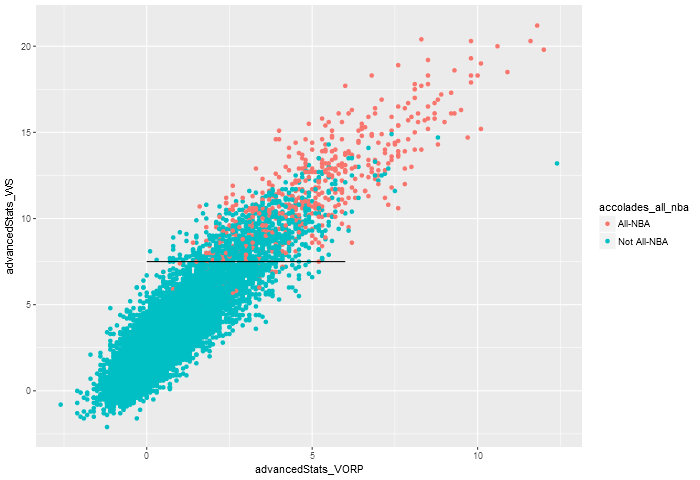

In [131]:
%%R -i allNbaTeamLine -w 700 -u px

# Plot classification of manual line model
allNbaPlotLineAllNba = ggplot(
    NULL
) +
geom_point(
    data = playerAggDfAllNbaAllStar,
    aes(
        x = advancedStats_VORP,
        y = advancedStats_WS,
        color = accolades_all_nba
    )
) + geom_line(
    data = allNbaTeamLine,
    aes(
        x = xs,
        y = ys
    )
)

allNbaPlotLineAllNba

_**OR**_... you want to go the opposite direction and only classify for those players who are _**BAR NONE**_ all-NBA level players and you want to be as sure as possible, and maybe your decision boundary is here:

In [139]:
notAllNbaTeamLine = pd.DataFrame({
    'xs': [3, 7.5],
    'ys': [15, 7.5]
})

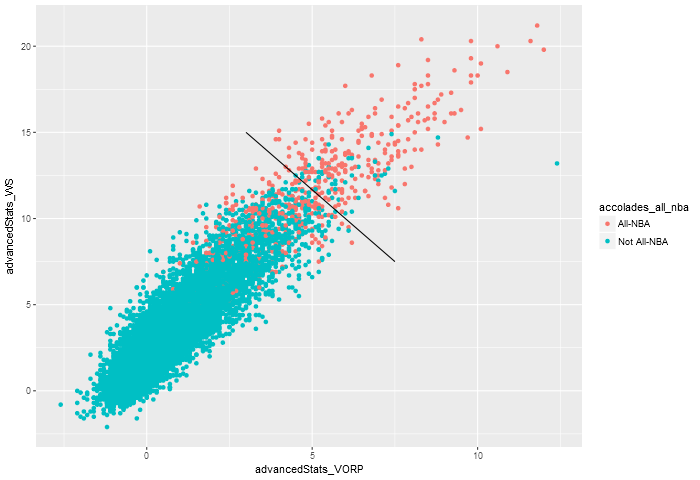

In [140]:
%%R -i notAllNbaTeamLine -w 700 -u px

# Plot classification of manual line model
allNbaPlotLineNotAllNba = ggplot(
    NULL
) +
geom_point(
    data = playerAggDfAllNbaAllStar,
    aes(
        x = advancedStats_VORP,
        y = advancedStats_WS,
        color = accolades_all_nba
    )
) + geom_line(
    data = notAllNbaTeamLine,
    aes(
        x = xs,
        y = ys
    )
)

allNbaPlotLineNotAllNba

Who knows, right? And not who knows in the sense of 'I don't know what the right answer is', but who knows in the sense of 'how will one straight line govern what everyone in the world will ever want?'. Everybody is doing analysis for different reasons, and the data set will appeal to people in different ways depending on their context, knowledge, and objectives.

Again, I'm really coming into these series of analysis with no objective other than to learn more information, so perhaps the route that I will take is I'll try to look at the shift of the line from a sensitivity perspective. With each change in the line, how much better / worse does our all-NBA / not all-NBA predictors go up / down by? I think I need to gather that information before we go any further.

The way I'll generate my new lines is just by changing the b-value in

$$y=mx+b$$

This will keep my axis (as the slope m is staying constant), but move my line up and down along the axis of intersection. We can think about this as me moving my line perpendicular to the first principal component here (because we already know what principal components are... right??).

I'm going to take b values from

$$b=0,2,4,...,36,38,40$$

and generate lines using the same slope of

$$m=\frac{-10}{5.5}$$

In [166]:
# Initiate list of b values
bValues = range(0, 42, 2)

# Initiate empty dict to store accuracy results
accuracyResults = {}

# For each line, calculate the prediction metrics using the same process as before
for b in bValues:
    # Initiate our two points on the line that we need to feed into the formula to calculate the d value
    x1 = 0
    y1 = b
    x2 = 1
    y2 = float(-10)/5.5*float(x2)+float(b)
    
    print 'Calculating points on line b = {}, where x1 = {}, y2 = {} x2 = {}, y2 = {}'.format(
        b, x1, y1, x2, y2
    )

    # Determine value of d for each sample point
    playerAggDfAllNbaAllStar['temp_manual_line_d_value'] = (playerAggDfAllNbaAllStar['advancedStats_VORP']-x1)*(y2-y1)-(playerAggDfAllNbaAllStar['advancedStats_WS']-y1)*(x2-x1)

    # Predict using our manual line model
    ##########################################################
    ##### CHANGE THE SIGN FOR EVALUATING THE D VALUE HERE#####
    ##########################################################
    playerAggDfAllNbaAllStar['temp_manual_line_predict'] = np.where(
        (playerAggDfAllNbaAllStar['temp_manual_line_d_value'] < 0),
        'All-NBA',
        'Not All-NBA'
    )

    # Label successfully classified and wrongly classified
    playerAggDfAllNbaAllStar['temp_manual_line_labels'] = np.where(
        (playerAggDfAllNbaAllStar['temp_manual_line_predict'] == 'All-NBA') & (playerAggDfAllNbaAllStar['accolades_all_nba'] == 'All-NBA'),
        'All-NBA - Successfully Classified',
        np.where(
            (playerAggDfAllNbaAllStar['temp_manual_line_predict'] == 'All-NBA') & (playerAggDfAllNbaAllStar['accolades_all_nba'] == 'Not All-NBA'),
            'All-NBA - Wrongly Classified',
            np.where(
                (playerAggDfAllNbaAllStar['temp_manual_line_predict'] == 'Not All-NBA') & (playerAggDfAllNbaAllStar['accolades_all_nba'] == 'All-NBA'),
                'Not All-NBA - Wrongly Classified',
                'Not All-NBA - Successfully Classified'
            )
        )
    )
    
    # Count the occurences of each prediction outcome, fill missing labels with 0 (e.g. if b = 0, then there will be no wrongly
    #   classified all-NBA guys because everyone will be all-NBA, in this scenario there will be no 'All-NBA - Wrongly Classified'
    #   labels in the data, and the calculations in the section below will result in an error)
    labelCountsLine = playerAggDfAllNbaAllStar['temp_manual_line_labels'].value_counts()
    if 'All-NBA - Successfully Classified' not in labelCountsLine.keys(): labelCountsLine['All-NBA - Successfully Classified'] = 0
    if 'All-NBA - Wrongly Classified' not in labelCountsLine.keys(): labelCountsLine['All-NBA - Wrongly Classified'] = 0
    if 'Not All-NBA - Wrongly Classified' not in labelCountsLine.keys(): labelCountsLine['Not All-NBA - Wrongly Classified'] = 0
    if 'Not All-NBA - Successfully Classified' not in labelCountsLine.keys(): labelCountsLine['Not All-NBA - Successfully Classified'] = 0
    
    # Store results
    accuracyResults[b] = {}
    
    accuracyResults[b]['all_nba_successfully_classified'] = labelCountsLine['All-NBA - Successfully Classified']
    accuracyResults[b]['all_nba_all_samples'] = labelCountsLine['All-NBA - Successfully Classified'] + labelCountsLine['Not All-NBA - Wrongly Classified']
    accuracyResults[b]['all_nba_perc_correct'] = float(labelCountsLine['All-NBA - Successfully Classified']) / float(labelCountsLine['All-NBA - Successfully Classified'] + labelCountsLine['Not All-NBA - Wrongly Classified'])*100
    accuracyResults[b]['not_all_nba_successfully_classified'] = labelCountsLine['Not All-NBA - Successfully Classified']
    accuracyResults[b]['not_all_nba_all_samples'] = labelCountsLine['Not All-NBA - Successfully Classified'] + labelCountsLine['All-NBA - Wrongly Classified']
    accuracyResults[b]['not_all_nba_perc_correct'] = float(labelCountsLine['Not All-NBA - Successfully Classified']) / float(labelCountsLine['Not All-NBA - Successfully Classified'] + labelCountsLine['All-NBA - Wrongly Classified'])*100
    
# Save our results dict into a datframe so we can plot
accuracyResultsDf = pd.DataFrame(accuracyResults).transpose().reset_index()
accuracyResultsDf.rename(columns = {'index': 'b'}, inplace = True)
accuracyResultsDf

Calculating points on line b = 0, where x1 = 0, y2 = 0 x2 = 1, y2 = -1.81818181818
Calculating points on line b = 2, where x1 = 0, y2 = 2 x2 = 1, y2 = 0.181818181818
Calculating points on line b = 4, where x1 = 0, y2 = 4 x2 = 1, y2 = 2.18181818182
Calculating points on line b = 6, where x1 = 0, y2 = 6 x2 = 1, y2 = 4.18181818182
Calculating points on line b = 8, where x1 = 0, y2 = 8 x2 = 1, y2 = 6.18181818182
Calculating points on line b = 10, where x1 = 0, y2 = 10 x2 = 1, y2 = 8.18181818182
Calculating points on line b = 12, where x1 = 0, y2 = 12 x2 = 1, y2 = 10.1818181818
Calculating points on line b = 14, where x1 = 0, y2 = 14 x2 = 1, y2 = 12.1818181818
Calculating points on line b = 16, where x1 = 0, y2 = 16 x2 = 1, y2 = 14.1818181818
Calculating points on line b = 18, where x1 = 0, y2 = 18 x2 = 1, y2 = 16.1818181818
Calculating points on line b = 20, where x1 = 0, y2 = 20 x2 = 1, y2 = 18.1818181818
Calculating points on line b = 22, where x1 = 0, y2 = 22 x2 = 1, y2 = 20.1818181818


b  all_nba_all_samples  all_nba_perc_correct  \
0    0                502.0            100.000000   
1    2                502.0            100.000000   
2    4                502.0             99.800797   
3    6                502.0             99.402390   
4    8                502.0             98.406375   
5   10                502.0             97.211155   
6   12                502.0             93.027888   
7   14                502.0             85.258964   
8   16                502.0             74.501992   
9   18                502.0             63.545817   
10  20                502.0             49.003984   
11  22                502.0             37.450199   
12  24                502.0             26.294821   
13  26                502.0             18.127490   
14  28                502.0             12.350598   
15  30                502.0              9.163347   
16  32                502.0              5.776892   
17  34                502.0              2.988048   
18  36                502.0              1.992032   
19  38                502.0              1.195219   
20  40                502.0              0.597610   

    all_nba_successfully_classified  not_all_nba_all_samples  \
0                             502.0                  12718.0   
1                             502.0                  12718.0   
2                             501.0                  12718.0   
3                             499.0                  12718.0   
4                             494.0                  12718.0   
5                             488.0                  12718.0   
6                             467.0                  12718.0   
7                             428.0                  12718.0   
8                             374.0                  12718.0   
9                             319.0                  12718.0   
10                            246.0                  12718.0   
11                            188.0                  12718.0   
12                            132.0                  12718.0   
13                             91.0                  12718.0   
14                             62.0                  12718.0   
15                             46.0                  12718.0   
16                             29.0                  12718.0   
17                             15.0                  12718.0   
18                             10.0                  12718.0   
19                              6.0                  12718.0   
20                              3.0                  12718.0   

    not_all_nba_perc_correct  not_all_nba_successfully_classified  
0                  14.530587                               1848.0  
1                  41.602453                               5291.0  
2                  59.435446                               7559.0  
3                  71.740840                               9124.0  
4                  80.932537                              10293.0  
5                  87.584526                              11139.0  
6                  92.294386                              11738.0  
7                  95.588929                              12157.0  
8                  97.633276                              12417.0  
9                  98.899198                              12578.0  
10                 99.543953                              12660.0  
11                 99.764114                              12688.0  
12                 99.874194                              12702.0  
13                 99.960686                              12713.0  
14                 99.976411                              12715.0  
15                 99.984274                              12716.0  
16                 99.992137                              12717.0  
17                 99.992137                              12717.0  
18                100.000000                              12718.0  
19                100.000000                              12718.0  
2

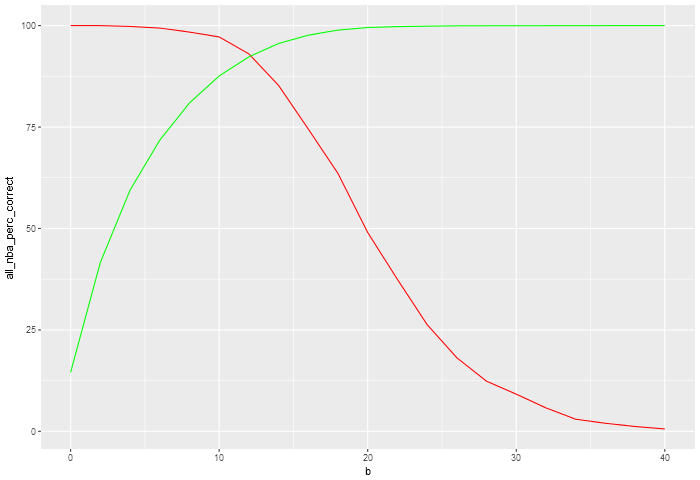

In [168]:
%%R -i accuracyResultsDf -w 700 -u px

ggplot(
    accuracyResultsDf,
    aes(
        x = b
    )
) + 
geom_line(
    aes(
        y = all_nba_perc_correct
    ),
    color = 'red'
) +
geom_line(
    aes(
        y = not_all_nba_perc_correct
    ),
    color = 'green'
)

Therein lies our answer... Roughly

$$b=12$$

provides us with the point that completely maximizes the accuracy of both classes... and it's allowing both classes at like 90%!! Looking at where b=12 on the table above, both classes actually sit around 92%. WAY more than what I had anticipated actually.

Let's model this one more time with the line b=12.

In [175]:
# Initiate list of b values
bValues = [12]

# Initiate empty dict to store accuracy results
accuracyResults = {}

# For each line, calculate the prediction metrics using the same process as before
for b in bValues:
    # Initiate our two points on the line that we need to feed into the formula to calculate the d value
    x1 = 0
    y1 = b
    x2 = 6
    y2 = float(-10)/5.5*float(x2)+float(b)
    
    print 'Calculating points on line b = {}, where x1 = {}, y2 = {} x2 = {}, y2 = {}'.format(
        b, x1, y1, x2, y2
    )

    # Determine value of d for each sample point
    playerAggDfAllNbaAllStar['temp_manual_line_d_value'] = (playerAggDfAllNbaAllStar['advancedStats_VORP']-x1)*(y2-y1)-(playerAggDfAllNbaAllStar['advancedStats_WS']-y1)*(x2-x1)

    # Predict using our manual line model
    ##########################################################
    ##### CHANGE THE SIGN FOR EVALUATING THE D VALUE HERE#####
    ##########################################################
    playerAggDfAllNbaAllStar['temp_manual_line_predict'] = np.where(
        (playerAggDfAllNbaAllStar['temp_manual_line_d_value'] < 0),
        'All-NBA',
        'Not All-NBA'
    )

    # Label successfully classified and wrongly classified
    playerAggDfAllNbaAllStar['temp_manual_line_labels'] = np.where(
        (playerAggDfAllNbaAllStar['temp_manual_line_predict'] == 'All-NBA') & (playerAggDfAllNbaAllStar['accolades_all_nba'] == 'All-NBA'),
        'All-NBA - Successfully Classified',
        np.where(
            (playerAggDfAllNbaAllStar['temp_manual_line_predict'] == 'All-NBA') & (playerAggDfAllNbaAllStar['accolades_all_nba'] == 'Not All-NBA'),
            'All-NBA - Wrongly Classified',
            np.where(
                (playerAggDfAllNbaAllStar['temp_manual_line_predict'] == 'Not All-NBA') & (playerAggDfAllNbaAllStar['accolades_all_nba'] == 'All-NBA'),
                'Not All-NBA - Wrongly Classified',
                'Not All-NBA - Successfully Classified'
            )
        )
    )
    
    # Count the occurences of each prediction outcome, fill missing labels with 0 (e.g. if b = 0, then there will be no wrongly
    #   classified all-NBA guys because everyone will be all-NBA, in this scenario there will be no 'All-NBA - Wrongly Classified'
    #   labels in the data, and the calculations in the section below will result in an error)
    labelCountsLine = playerAggDfAllNbaAllStar['temp_manual_line_labels'].value_counts()
    if 'All-NBA - Successfully Classified' not in labelCountsLine.keys(): labelCountsLine['All-NBA - Successfully Classified'] = 0
    if 'All-NBA - Wrongly Classified' not in labelCountsLine.keys(): labelCountsLine['All-NBA - Wrongly Classified'] = 0
    if 'Not All-NBA - Wrongly Classified' not in labelCountsLine.keys(): labelCountsLine['Not All-NBA - Wrongly Classified'] = 0
    if 'Not All-NBA - Successfully Classified' not in labelCountsLine.keys(): labelCountsLine['Not All-NBA - Successfully Classified'] = 0
    
    # Store results
    accuracyResults[b] = {}
    
    accuracyResults[b]['all_nba_successfully_classified'] = labelCountsLine['All-NBA - Successfully Classified']
    accuracyResults[b]['all_nba_all_samples'] = labelCountsLine['All-NBA - Successfully Classified'] + labelCountsLine['Not All-NBA - Wrongly Classified']
    accuracyResults[b]['all_nba_perc_correct'] = float(labelCountsLine['All-NBA - Successfully Classified']) / float(labelCountsLine['All-NBA - Successfully Classified'] + labelCountsLine['Not All-NBA - Wrongly Classified'])*100
    accuracyResults[b]['not_all_nba_successfully_classified'] = labelCountsLine['Not All-NBA - Successfully Classified']
    accuracyResults[b]['not_all_nba_all_samples'] = labelCountsLine['Not All-NBA - Successfully Classified'] + labelCountsLine['All-NBA - Wrongly Classified']
    accuracyResults[b]['not_all_nba_perc_correct'] = float(labelCountsLine['Not All-NBA - Successfully Classified']) / float(labelCountsLine['Not All-NBA - Successfully Classified'] + labelCountsLine['All-NBA - Wrongly Classified'])*100
    
# Save our results dict into a datframe so we can plot
accuracyResultsDf = pd.DataFrame(accuracyResults).transpose().reset_index()
accuracyResultsDf.rename(columns = {'index': 'b'}, inplace = True)
accuracyResultsDf

Calculating points on line b = 12, where x1 = 0, y2 = 12 x2 = 6, y2 = 1.09090909091


b  all_nba_all_samples  all_nba_perc_correct  \
0  12                502.0             93.027888   

   all_nba_successfully_classified  not_all_nba_all_samples  \
0                            467.0                  12718.0   

   not_all_nba_perc_correct  not_all_nba_successfully_classified  
0                 92.302249                              11739.0

In [176]:
tempManualDecisionLine = pd.DataFrame({
    'xs': [0, 6],
    'ys': [12, 1.09]
})

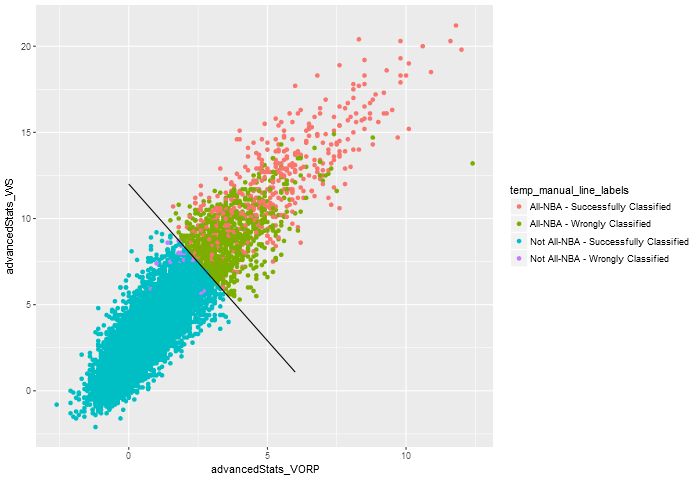

In [177]:
%%R -i playerAggDfAllNbaAllStar -i tempManualDecisionLine -w 700 -u px

# Plot classification of manual line model
optimizedAllNbaPlotLine = ggplot(
    NULL
) +
geom_point(
    data = playerAggDfAllNbaAllStar,
    aes(
        x = advancedStats_VORP,
        y = advancedStats_WS,
        color = temp_manual_line_labels
    )
) + geom_line(
    data = tempManualDecisionLine,
    aes(
        x = xs,
        y = ys
    )
)

optimizedAllNbaPlotLine

Welp, that is absolutely not what I had in mind when I started this analysis. Oh how our eyes can fool us so badly... This honestly looks like it's cutting into like 1/3 of the non all-NBA cluster...

Let me try to alpha the dots so we can see density a bit better...

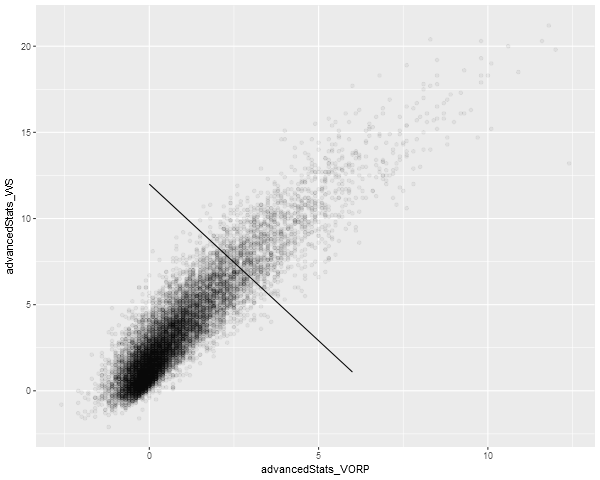

In [184]:
%%R -i playerAggDfAllNbaAllStar -i tempManualDecisionLine -w 600 -u px

# Plot classification of manual line model
optimizedAllNbaPlotLine = ggplot(
    NULL
) +
geom_point(
    data = playerAggDfAllNbaAllStar,
    aes(
        x = advancedStats_VORP,
        y = advancedStats_WS
    ),
    alpha = 0.05
) + geom_line(
    data = tempManualDecisionLine,
    aes(
        x = xs,
        y = ys
    )
)

optimizedAllNbaPlotLine

There you go man... most players (as we could have guessed, I suppose) fall within that huge cluster in the bottom left hand corner and the players really spread thin throughout the top right hand corner of the plot. I really, really needed that visual reinforcement to believe those 93% / 92% numbers.

## Can We Do This Easier...
So... was that hard? Not really. It was pretty intuitive. This post took me about 8 hours to put together, so in the grand scheme of things, if I'm trying to build a working model, am I upset that it took me 8 hours to optimize this one measly linear line? The answer is also an art, I suppose. I'm actually quite happy with how my reults turned out because I've never done this before. To me the value came from a learning experience. The learnings in performing and implementing the classification scheme, the learnings in performing the sensitivity analysis. The learnings in the flaws of visualization... All of this was well worth the 8 hours for me.

However, at the end of the day again, all I did was optimize a frickin line. A single line. What is to the left of it, what is to the right of it, rinse, and repeat... There are better ways to come to the conclusion, _**as long as I understand what those better ways are doing**_. If I ran an out-of-the-box model, generally the result I would get is where the line was fit. I may not understand why they chose a line, why they chose that line, the whole criteria of what made a good line and what made a bad line... etc. All of these are unanswered questions if I'm not building my own model.

Having done this, I could literally just run this notebook again and find and optimize that line in seconds. My decision boundary, however, has a _**specific slope**_ that I chose _**by eye**_. What if the data in the next few years skews the axis of interception? What if the slope needs to be tweaked? Better yet, what if I was in a completely different environment and needed to do this type of analysis every night on hundreds of data sets? Am I going to take a look at every data set and find the slope myself? If I have 500 data sets and it takes even 15 seconds to look at these, that's 125 minutes, nearly two hours to go through them all. And if I have to do this every night? Depending on what my day job is I'd probably consider keeping it.

_**EVEN WORSE**_... What if the decision boundary changes? What if a line or rectangle won't work anymore? What will we do then? Well, I guess that's besides the point because our model would just not work altogether even if we could look at it and manually decide on a non-linear boundary, but now I think we're getting into the ins and outs of advanced analytics, and dare I say... "machine learning".

In the next few posts, I will focus on using different models so solve this problem!